# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [67]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import math

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [68]:
def add_ones_to_left(X: np.ndarray) -> np.ndarray:
    left_ones = np.ones((X.shape[0], 1))
    return np.hstack((left_ones, X))


class Perceptron:

    def __init__(self, iterations=100):
        self.w = None
        self.iterations = iterations
        self.labels = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        mx_abs = max(np.max(abs(X)), np.max(abs(y)))
        self.w = np.random.rand(X.shape[1] + 1, 1).astype(dtype=np.float64) * (2 * mx_abs) - mx_abs
        X = add_ones_to_left(X)
        
        self.labels = np.unique(y)
        assert len(self.labels) == 2
        y = np.array(list(map(lambda x: 1 if x == self.labels[1] else -1, y.reshape(-1)))).reshape(-1, 1)
        
        for _ in range(self.iterations):
            y_pred = self.inner_predict(X) * 2 - 1
            any_error = 0
            for i in range(len(y)):
                if y[i][0] != y_pred[i][0]:
                    self.w += y[i][0] * X[i].reshape(-1, 1)
                    any_error = 1
                    break
            if not any_error:
                break

    def inner_predict(self, X):
        return (X.dot(self.w) >= 0).astype(dtype=int)
    
    def predict(self, X):
        return np.array(list(map(lambda x: self.labels[int(x)], self.inner_predict(add_ones_to_left(X))))).reshape(-1)

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

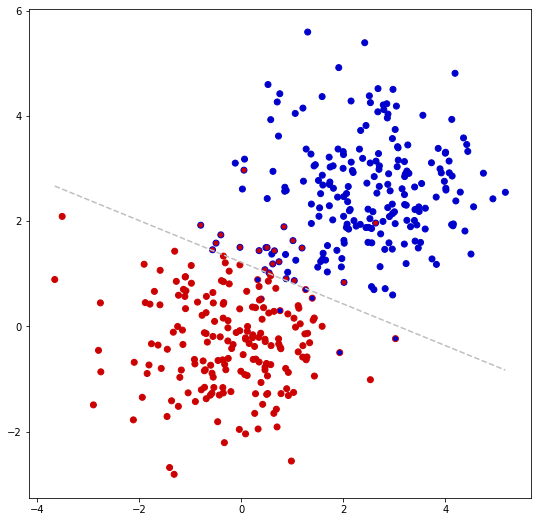

In [73]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

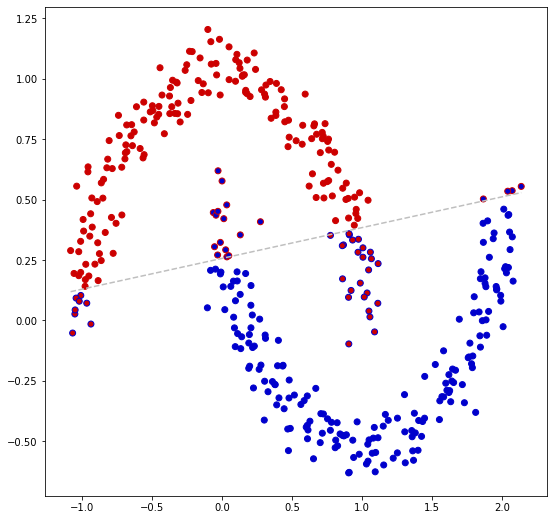

In [74]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [317]:
class PerceptronBest:

    def __init__(self, iterations=100):
        self.w = None
        self.iterations = iterations
        self.labels = None
        self.best_w = None
        self.best_count_ok = -math.inf

    def fit(self, X: np.ndarray, y: np.ndarray):
        mx_abs = max(np.max(abs(X)), np.max(abs(y)))
        self.w = np.random.rand(X.shape[1] + 1, 1).astype(dtype=np.float64) * (2 * mx_abs) - mx_abs
        X = add_ones_to_left(X)
        
        self.labels = np.unique(y)
        assert len(self.labels) == 2
        y = np.array(list(map(lambda x: 1 if x == self.labels[1] else -1, y.reshape(-1)))).reshape(-1, 1)
        
        self.best_w = np.copy(self.w)
        
        for _ in range(self.iterations):
            y_pred = self.inner_predict(X) * 2 - 1
            any_error = 0
            for i in range(len(y)):
                if y[i][0] != y_pred[i][0]:
                    self.w += y[i][0] * X[i].reshape(-1, 1)
                    any_error = 1
                    break
            count_ok = np.sum(y == y_pred)
            if count_ok > self.best_count_ok:
                self.best_count_ok = count_ok
                self.best_w = np.copy(self.w)
            if not any_error:
                break
            
        self.w = self.best_w

    def inner_predict(self, X):
        return (X.dot(self.w) >= 0).astype(dtype=int)
    
    def predict(self, X):
        return np.array(list(map(lambda x: self.labels[int(x)], self.inner_predict(add_ones_to_left(X))))).reshape(-1)

In [318]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

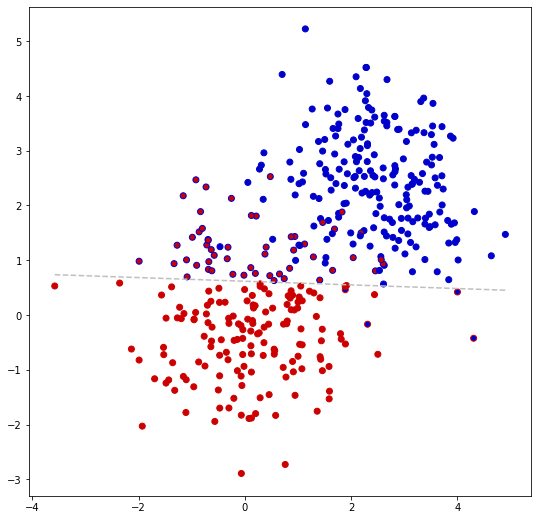

In [319]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

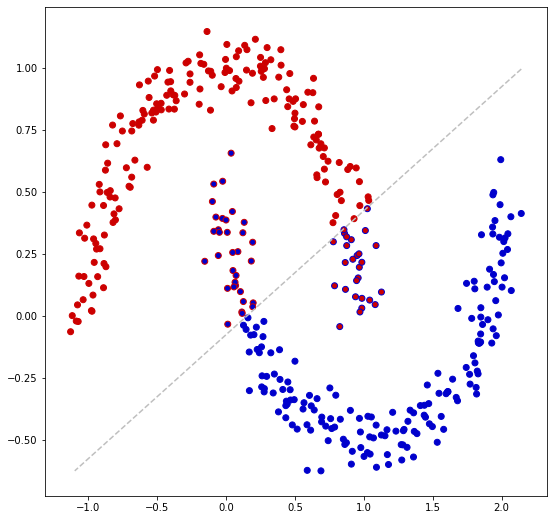

In [320]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [391]:
def get_image_feature1(image):
    result = 0
    n = len(image)
    for i in range(n):
        for j in range(n):
#             result += abs(image[i][j] - image[i][n - 1 - j])
            result += abs(image[i][j] - image[n - 1 - i][j])
    return result


def get_image_feature2(image):
    result = 0
    n = len(image)
    return np.mean(image[n // 2 - 2: n // 2 + 1, n // 2 - 2: n // 2 + 1])


def transform_images(images):
    return np.array([
        [
            get_image_feature1(image),
            get_image_feature2(image)
        ]
        for image in images
    ]).reshape(-1, 2)


def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

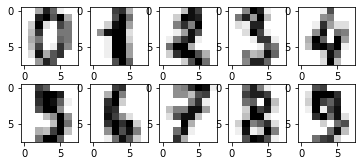

In [392]:
def show_digit(k):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    
    # plt.figure(1, figsize=(3, 3))
    plt.subplot(3, 5, k + 1)
    plt.imshow(images[k], cmap=plt.cm.gray_r, interpolation='nearest')
    # plt.show()

    # print(f'{labels[k]}')
#     print((images[k] > np.mean(images[k])).astype(dtype=int))
show_digit(0)
show_digit(1)
show_digit(2)
show_digit(3)
show_digit(4)
show_digit(5)
show_digit(6)
show_digit(7)
show_digit(8)
show_digit(9)
plt.show()

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что выборка разбивается детерминировано, т.е. неи смысла считать среднюю точность__ 

In [396]:
X, y = get_digits(3, 8)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

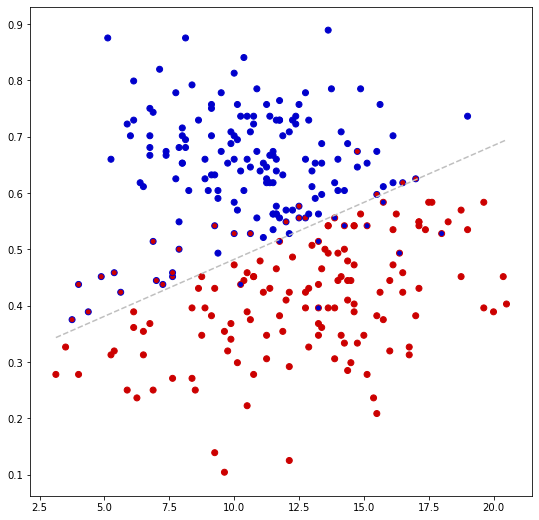

Accuracy: 0.6805555555555556


In [397]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

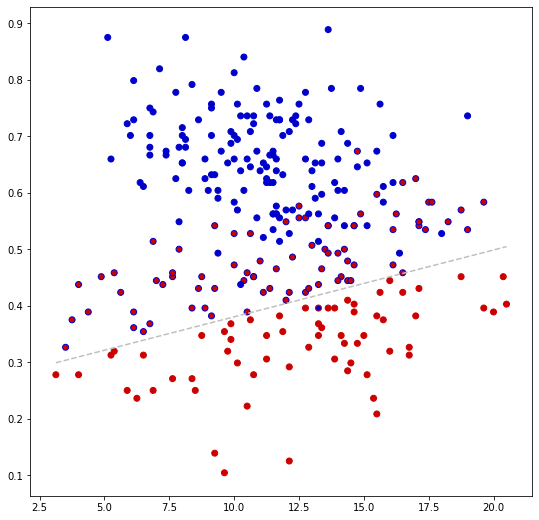

Accuracy: 0.5972222222222222


In [398]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))